## **Finding a maximum independant set using a quantum computer with neutral atoms**

The first step is to create a register with a given geometrical graph.

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

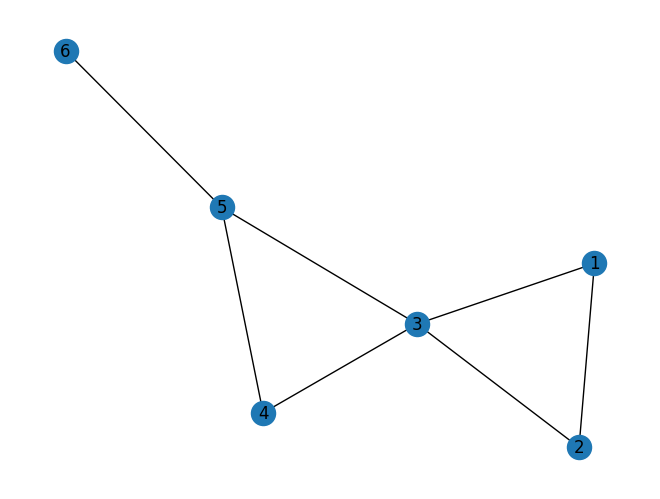

In [4]:
#creating a graph with determinated edges

G = nx.Graph()
edges = np.array([(1, 2), (1, 3), (2,3), (3, 4), (3, 5),(4, 5), (5, 6)])
G.add_edges_from(edges)

#setting the position of the nodes using spring_layout
pos = nx.spring_layout(G, seed = 42)#the seed can be changed, but the seed 42 is used by the Quantum_MIS class

#plot the graph
nx.draw(G, pos = pos, with_labels = True)
plt.show()

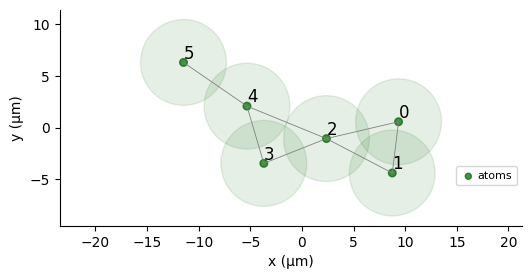

In [6]:
#creating the quantum solver object
from QMIS_code.Quantum_MIS import Quantum_MIS

#we only need to pass the graph object in the Quantum_MIS class
mis_solution = Quantum_MIS(G)

#the Quantum_MIS class creates a register
# we can now print the register created
mis_solution.print_reg() 


Now that we have created the register, we need to create a Pulse. In this project, 5 types of pulse have been implemented. 
- "Rise_Sweep_Fall" -> A pulse that starts to 0, rises during a quarter of the total time to the omega specified, stays constant during half of the total time, and falls to 0 during a quarter of the total time.

- "Pyramid" -> A pulse that starts at a certain value that is Omega - delta. The pulse stays at this value for a quarter of the total time, does a Rise_Fall pulse for half of the total time, and finally stays constant at Omega-delta for the last quarter of the total time.

- "Blackman" -> This pulse is a normal form with a total area of Omega with a lenght given by the time.

- "Rise_Fall" -> This pulse is only the rise and fall part of the Rise_Sweep_Fall pulse. It rises during half of the time from 0 to Omega and falls back to 0 for the last half of the total time.

- "Waveform" -> This pulse starts at 0, is at Omega at half of the total time, and falls back to 0 at the end, but follows a waveform pattern instead of a linear pattern like the Rise_Fall. 

In [ ]:
T = 4000 #time of the pulse in ns, the time limit is 4000.

pulse_type = "Rise_Sweep_Fall" #the pulse type used.